## To do
Write to dos here

In [1]:
import os
import sys

import pwlf
import warnings
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

from pems_util import *
from shapely import geometry
from keplergl import KeplerGl

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2]:
# --- Global variables

# Setting up the Coordinate Reference Systems up front in the necessary format.
crs_degree = {'init': 'epsg:4326'} # CGS_WGS_1984 (what the GPS uses)

# --- Paths

# Root path of Fremont Dropbox

# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from fremontdropbox import get_dropbox_location
# Root path of the Dropbox business account
dbx = get_dropbox_location()

# Temporary! Location of the folder where the restructuring is currently happening
data_path = dbx + '/Private Structured data collection'

## 1. Creation of the project delimitation

In [3]:
## create the project delimitation

# this code creates the project delimitation from a set of points
p = []
p.append((-121.94277062699996, 37.55273259000006))
p.append((-121.94099807399999, 37.554268507000074))
p.append((-121.91790942699998, 37.549823434000075))
p.append((-121.89348666299998, 37.52770136500004))
p.append((-121.90056572499998, 37.52292299800007))
p.append((-121.90817571699995, 37.52416183400004))
p.append((-121.91252749099999, 37.51845069500007))
p.append((-121.91349347899995, 37.513972023000065))
p.append((-121.90855417099999, 37.503837324000074))
p.append((-121.91358547299996, 37.50097863000008))
p.append((-121.90798018999999, 37.49080413200005))
p.append((-121.91894942199997, 37.48791568200005))
p.append((-121.92029048799998, 37.488706567000065))
p.append((-121.93070953799997, 37.48509600500006))
p.append((-121.93254686299997, 37.48864173700008))
p.append((-121.94079404499996, 37.50416395900004))
p.append((-121.94569804899999, 37.51332606200003))
p.append((-121.94918207899997, 37.520371545000046))
p.append((-121.95305006999996, 37.52804520800004))
p.append((-121.953966735, 37.53272020000003))
p.append((-121.95428756799998, 37.53817435800005))
p.append((-121.95506236799997, 37.54107322100003))
p.append((-121.95676186899999, 37.54656695700004))
p.append((-121.95529950799994, 37.54980786700003))
p.append((-121.95261192399994, 37.550479763000055))
p.append((-121.94988481799999, 37.55277211300006))
p.append((-121.94613010599994, 37.55466923100005))
p.append((-121.94277062699996, 37.55273259000006))

delimitation_poly = geometry.Polygon([[po[0], po[1]] for po in p])

project_del = gpd.GeoDataFrame({'Type': ['Delimitation','Box'], 'geometry': [delimitation_poly, delimitation_poly.envelope]})

lat = [i[0] for i in delimitation_poly.envelope.exterior.coords]
lng = [i[1] for i in delimitation_poly.envelope.exterior.coords]
lat_min = min(lat)
lat_max = max(lat)
lng_min = min(lng)
lng_max = max(lng)
print("Box delimitation: " + str((lat_min, lat_max, lng_min, lng_max)))

project_del.crs = 'epsg:4326'
project_del_path = dbx + "/Private Structured data collection/Manual-made dataset (do not touch)/Network/Map/Project Delimitation/Project_delimitation.shp"
project_del.to_file(project_del_path)

Box delimitation: (-121.95676186899999, -121.89348666299998, 37.48509600500006, 37.55466923100005)


## PeMS Fetching and Parsing

In [4]:
PeMSConnection.initialize()

PeMS Username: ········
PeMS Password: ········

A connection has been successfully initialized! Please note that the PeMS website is not secure.



In [ ]:
pems_polygon = delimitation_poly
start_date = date(2020, 1, 3)
end_date = date(2020, 1, 3)
caltrans_shapefile = data_path + '/Data processing/Raw/Demand/OD demand/Caltrans Districts/District_201511.shp'
data_mode = "raw" # options: raw, meta, 5min, hour

pems_raw_polygon_data = fetch_pems_from_polygon(pems_polygon, start_date, end_date, caltrans_shapefile, data_mode)

In [ ]:
len(set(pems_raw_polygon_data['station_id'].values))
pems_raw_polygon_data

In [ ]:
pems_polygon = delimitation_poly
# NOTE: must always put 1 for day entry when data_mode = 'hour', as PeMS station_hour datasets only include YYYY_MM
start_date = date(2020, 1, 1) 
end_date = date(2020, 1, 1)
caltrans_shapefile = data_path + '/Data processing/Raw/Demand/OD demand/Caltrans Districts/District_201511.shp'
data_mode = "hour" # options: raw, meta, 5min, hour

pems_hourly_polygon_data = fetch_pems_from_polygon(pems_polygon, start_date, end_date, caltrans_shapefile, data_mode)

In [ ]:
pems_hourly_polygon_data

In [5]:
pems_polygon = delimitation_poly
# NOTE: must always put 1 for day entry when data_mode = 'hour', as PeMS station_hour datasets only include YYYY_MM
start_date = date(2020, 1, 3) 
end_date = date(2020, 1, 3)
caltrans_shapefile = data_path + '/Data processing/Raw/Demand/OD demand/Caltrans Districts/District_201511.shp'
data_mode = "5min" # options: raw, meta, 5min, hour

pems_5min_polygon_data = fetch_pems_from_polygon(pems_polygon, start_date, end_date, caltrans_shapefile, data_mode)

29.1kKB [00:08, 3.24kKB/s]                                                                                              


464KB [00:00, 1.53kKB/s]                                                                                                


Cleaning data...
Filtering data...
Done! Caltrans PeMS data for input region in specified date range has been generated and returned as a DataFrame.


In [6]:
pems_5min_polygon_data

,index,station_id,fwy,dir_x,district_x,county,city,state_pm,abs_pm,latitude,longitude,length,type,lanes,name,geometry,timestamp,district_y,fwy_no,dir_y,lane_type,station_length,sample_no,obs_percentage,total_flow,avg_occupancy,avg_speed,lane_0_samples,lane_0_flow,lane_0_avg_occ,lane_0_avg_speed,lane_0_observed,lane_1_samples,lane_1_flow,lane_1_avg_occ,lane_1_avg_speed,lane_1_observed,lane_2_samples,lane_2_flow,lane_2_avg_occ,lane_2_avg_speed,lane_2_observed,lane_3_samples,lane_3_flow,lane_3_avg_occ,lane_3_avg_speed,lane_3_observed,lane_4_samples,lane_4_flow,lane_4_avg_occ,lane_4_avg_speed,lane_4_observed,lane_5_samples,lane_5_flow,lane_5_avg_occ,lane_5_avg_speed,lane_5_observed,lane_6_samples,lane_6_flow,lane_6_avg_occ,lane_6_avg_speed,lane_6_observed,lane_7_samples,lane_7_flow,lane_7_avg_occ,lane_7_avg_speed,lane_7_observed
0,62496,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:00:00,4,680,N,ML,0.87,40,0,52.0,0.0131,68.2,10,11.0,0.0093,73.8,0,10.0,16.0,0.0144,70.1,0,10.0,14.0,0.0150,66.5,0,10.0,11.0,0.0137,62.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
1,62497,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:05:00,4,680,N,ML,0.87,40,0,51.0,0.0129,68.1,10,11.0,0.0091,73.7,0,10.0,15.0,0.0142,70.0,0,10.0,14.0,0.0148,66.4,0,10.0,11.0,0.0135,61.9,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
2,62498,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:10:00,4,680,N,ML,0.87,40,0,49.0,0.0125,67.9,10,10.0,0.0089,73.6,0,10.0,15.0,0.0138,69.9,0,10.0,13.0,0.0143,66.3,0,10.0,11.0,0.0130,61.8,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
3,62499,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:15:00,4,680,N,ML,0.87,40,0,49.0,0.0119,67.9,10,10.0,0.0084,73.6,0,10.0,15.0,0.0131,69.9,0,10.0,13.0,0.0136,66.3,0,10.0,11.0,0.0124,61.8,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
4,62500,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:20:00,4,680,N,ML,0.87,40,0,45.0,0.0113,67.8,10,9.0,0.0080,73.5,0,10.0,14.0,0.0124,69.8,0,10.0,12.0,0.0129,66.2,0,10.0,10.0,0.0118,61.7,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10363,1061851,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-03 23:35:00,4,680,S,OR,NaN,20,100,5.0,0.0024,NaN,10,1.0,0.0009,NaN,1,10.0,4.0,0.0038,NaN,1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
10364,1061852,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-03 23:40:00,4,680,S,OR,NaN,20,100,5.0,0.0021,NaN,10,1.0,0.0007,NaN,1,10.0,4.0,0.0035,NaN,1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
10365,1061853,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-03 23:45:00,4,680,S,OR,NaN,20,100,6.0,0.0026,NaN,10,2.0,0.0018,NaN,1,10.0,4.0,0.0033,NaN,1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0
10366,1061854,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51

In [9]:
pems_polygon = delimitation_poly
start_date = date(2020, 1, 3) 
end_date = date(2020, 1, 3)
caltrans_shapefile = data_path + '/Data processing/Raw/Demand/OD demand/Caltrans Districts/District_201511.shp'
data_mode = "meta" # options: raw, meta, 5min, hour

pems_meta_polygon_data = fetch_pems_from_polygon(pems_polygon, start_date, end_date, caltrans_shapefile, data_mode)

464KB [00:00, 778KB/s]                                                                                                  


464KB [00:00, 1.15kKB/s]                                                                                                


Cleaning data...
Filtering data...
Done! Caltrans PeMS data for input region in specified date range has been generated and returned as a DataFrame.


In [65]:
def plot_pems_vdf_by_id(station_id, pems_data, col1, col2, show_plots=True):
    station_id_data = pems_data[pems_data['station_id'] == station_id]     
        
    x, y = 12 * np.array(station_id_data[col1]), 1 / np.array(station_id_data[col2])

    if not np.isnan(np.sum(x)) and not np.isnan(np.sum(y)):
        my_pwlf = pwlf.PiecewiseLinFit(x, y)    
        result = my_pwlf.fit(3)   

        x_hat = np.linspace(min(x), max(x), num=10000)
        y_hat = my_pwlf.predict(x_hat)        
        
        max_speed = 1 / np.mean(y_hat[x_hat <= result[1]])
        road_capacity = np.mean(x_hat[(x_hat > result[2]) & (x_hat <= result[3])])
        
        if show_plots:
            plt.title("Section {} VDF".format(station_id))  
            plt.xlabel("Volume (veh / 5 min)")
            plt.ylabel("1 / Avg Speed")

            plt.scatter(x, y, label="Station {}".format(station_id))
            plt.plot(x_hat, y_hat, '-')
            
            plt.show()
        
            print("Estimated Max Speed: {} mph".format(max_speed))
            print("Estimated Road Capacity: {} vehicles".format(road_capacity))
            print("-------------------------------------------------------------------")
        
        return max_speed, road_capacity
    
    return None, None
    
def plot_pems_vdf_all(pems_data, col1, col2, show_plots=True):
    station_ids = set(pems_data['station_id'].values)
    
    max_speeds = {}
    road_capacities = {}
    
    for station_id in station_ids:
        max_speed, road_capacity = plot_pems_vdf_by_id(station_id, pems_data, col1, col2, show_plots)
        
        max_speeds[station_id] = max_speed
        road_capacities[station_id] = road_capacity
        
    return max_speeds, road_capacities

def gen_pems_map(pems_data, pems_metadata, col1, col2, show_plots=False):
    
    '''
    Lane Type Key:
    - CD (Coll/Dist)
    - CH (Conventional Highway)
    - FF (Fwy-Fwy connector)
    - FR (Off Ramp)
    - HV (HOV)
    - ML (Mainline)
    - OR (On Ramp)
    '''
    
    max_speeds, road_capacities = plot_pems_vdf_all(pems_data, col1, col2, show_plots)

    pems_metadata['est_maxspeed'] = pems_metadata['station_id'].map(max_speeds)
    pems_metadata['est_capacity'] = pems_metadata['station_id'].map(road_capacities)

    pems_station_data = pems_metadata[['station_id', 'name_x', 'est_maxspeed', 'est_capacity',\
                                                'type_x', 'length_x', 'lanes_x', 'fwy_x', 'geometry']]


    pems_station_gdf = gpd.GeoDataFrame(pems_station_data, geometry='geometry')

    pems_station_map = KeplerGl(height=600)
    pems_station_map.add_data(data=pems_station_gdf, name = "PeMS Stations")
    
    return pems_station_map

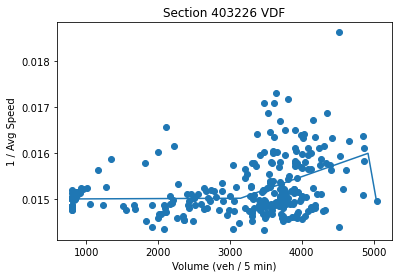

Estimated Max Speed: 66.63899155968666 mph
Estimated Road Capacity: 4980.690069006901 vehicles
-------------------------------------------------------------------


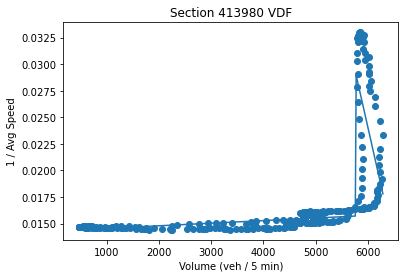

Estimated Max Speed: 66.37008127997461 mph
Estimated Road Capacity: 6031.949594959497 vehicles
-------------------------------------------------------------------


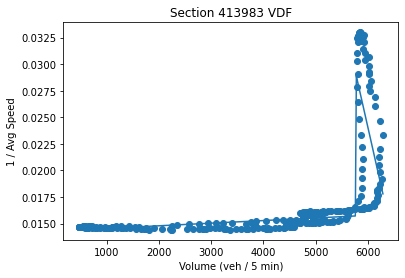

Estimated Max Speed: 66.35732720728971 mph
Estimated Road Capacity: 6033.699369936994 vehicles
-------------------------------------------------------------------


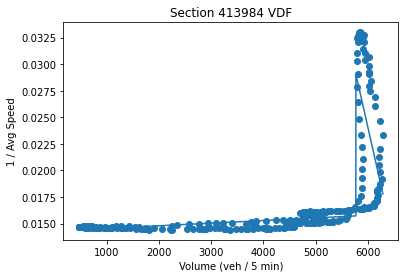

Estimated Max Speed: 66.345098771478 mph
Estimated Road Capacity: 6029.616561656167 vehicles
-------------------------------------------------------------------


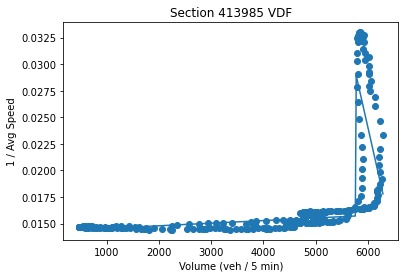

Estimated Max Speed: 66.36106247409269 mph
Estimated Road Capacity: 6032.824482448246 vehicles
-------------------------------------------------------------------


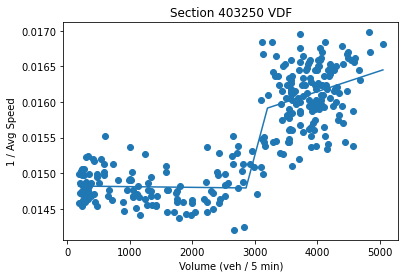

Estimated Max Speed: 67.53853806335829 mph
Estimated Road Capacity: 4127.445544554455 vehicles
-------------------------------------------------------------------


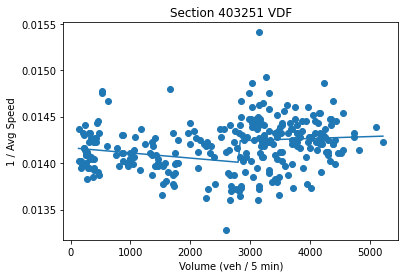

Estimated Max Speed: 71.0085303702491 mph
Estimated Road Capacity: 4026.744674467447 vehicles
-------------------------------------------------------------------


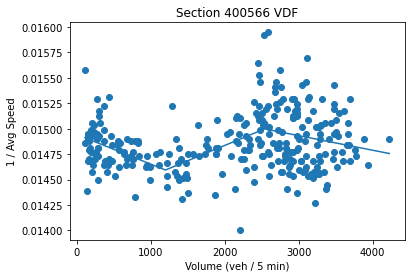

Estimated Max Speed: 67.78421548843275 mph
Estimated Road Capacity: 3379.518151815181 vehicles
-------------------------------------------------------------------


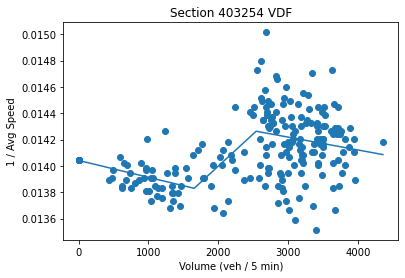

Estimated Max Speed: 71.76146539864628 mph
Estimated Road Capacity: 3448.3366336633667 vehicles
-------------------------------------------------------------------


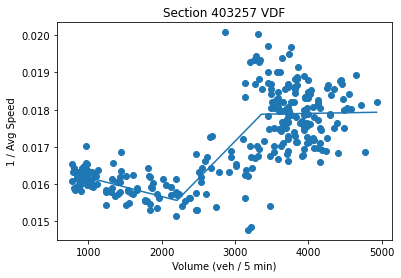

Estimated Max Speed: 62.79575274071937 mph
Estimated Road Capacity: 4146.570657065707 vehicles
-------------------------------------------------------------------


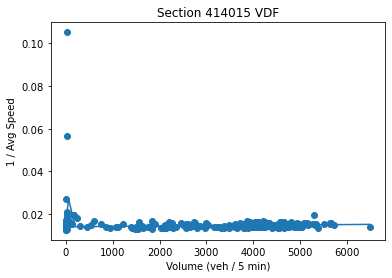

Estimated Max Speed: 46.52836268229755 mph
Estimated Road Capacity: 3345.3375337533753 vehicles
-------------------------------------------------------------------


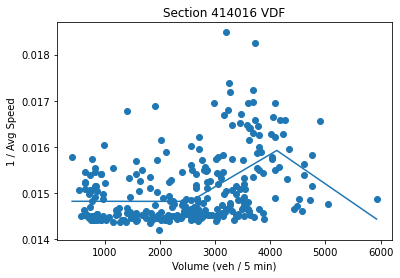

Estimated Max Speed: 67.4649031906289 mph
Estimated Road Capacity: 5022.905490549055 vehicles
-------------------------------------------------------------------


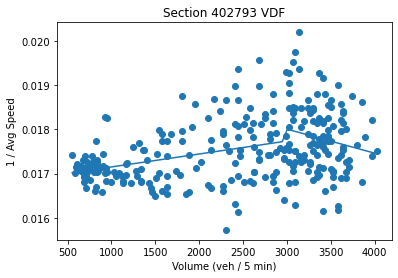

Estimated Max Speed: 57.574844146754 mph
Estimated Road Capacity: 3511.366936693669 vehicles
-------------------------------------------------------------------


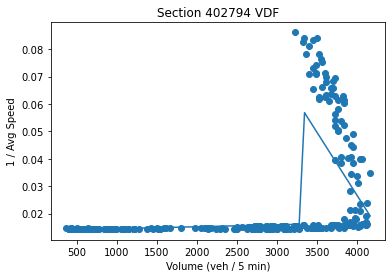

Estimated Max Speed: 66.4935117603268 mph
Estimated Road Capacity: 3753.8877887788776 vehicles
-------------------------------------------------------------------


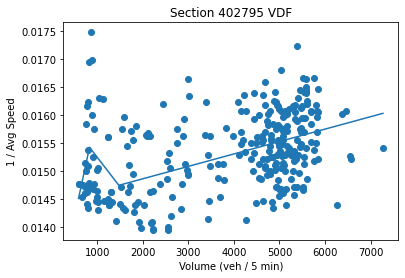

Estimated Max Speed: 66.81053628304038 mph
Estimated Road Capacity: 4371.5223522352235 vehicles
-------------------------------------------------------------------


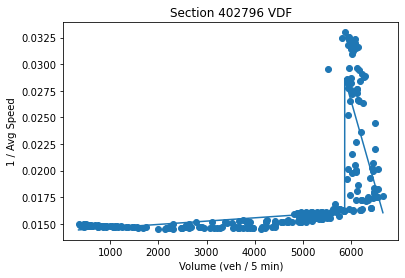

Estimated Max Speed: 65.479207789653 mph
Estimated Road Capacity: 6274.693069306931 vehicles
-------------------------------------------------------------------


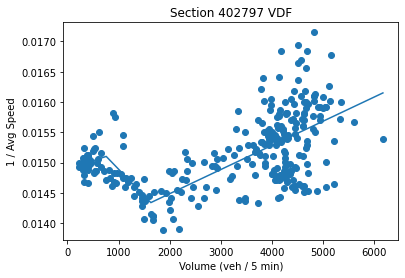

Estimated Max Speed: 66.54035579489681 mph
Estimated Road Capacity: 3898.2754275427537 vehicles
-------------------------------------------------------------------


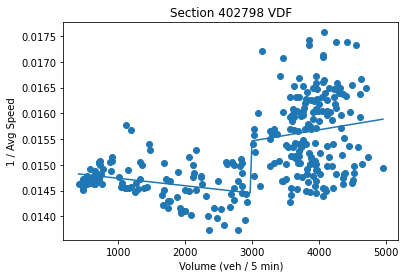

Estimated Max Speed: 68.30901661206586 mph
Estimated Road Capacity: 3977.1725172517254 vehicles
-------------------------------------------------------------------


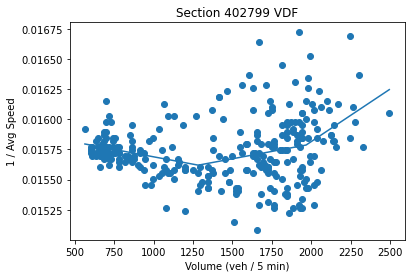

Estimated Max Speed: 63.663416895561504 mph
Estimated Road Capacity: 2231.1929192919292 vehicles
-------------------------------------------------------------------


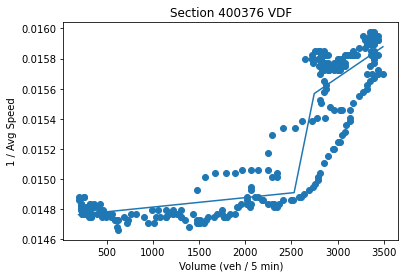

Estimated Max Speed: 67.39947405977075 mph
Estimated Road Capacity: 3119.227722772277 vehicles
-------------------------------------------------------------------
User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


In [68]:
pems_station_map = gen_pems_map(pems_5min_polygon_data, pems_meta_polygon_data,\
                                'total_flow', 'avg_speed', show_plots=True)

In [1]:
pems_station_map

NameError: name 'pems_station_map' is not defined

## To do: From OSM data create plots like the following ones (by parsing the data and converting it to shapefile):

In [50]:
# --- Global variables

# Setting up the Coordinate Reference Systems up front in the necessary format.
crs_degree = {'init': 'epsg:4326'} # CGS_WGS_1984 (what the GPS uses)

# --- Paths

# Root path of Fremont Dropbox

# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from fremontdropbox import get_dropbox_location
# Root path of the Dropbox business account
dbx = get_dropbox_location()

# Temporary! Location of the folder where the restructuring is currently happening
data_path = dbx + '/Private Structured data collection'

def to_gdf(path):
    gdf = gpd.GeoDataFrame.from_file(path)
    gdf = gdf.to_crs('epsg:4326')
    return gdf

aimsun_path = dbx + '/Private Structured data collection/Aimsun/Inputs/'

nodes = to_gdf(aimsun_path +'nodes.shp')
sections = to_gdf(aimsun_path +'sections.shp')

fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = nodes, name="nodes")
fremont_map.add_data(data = sections, name="sections")
fremont_map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'nodes': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2…

In [51]:
def to_gdf_csv(path):
# https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#from-wkt-format
    df = pd.read_csv(path)
    gdf = gpd.GeoDataFrame(
        df, crs='epsg:4326', geometry=gpd.points_from_xy(df.x, df.y))
    return gdf

network_infra_path = data_path + "/Manual-made dataset (do not touch)/Network/Infrastructure/"

stop_signs = to_gdf_csv(network_infra_path + "Stop signs location/Stop_Signs.csv")
traffic_lights = to_gdf_csv(network_infra_path + "Traffic lights location/Traffic_Lights.csv")

fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = stop_signs, name="Stop signs")
fremont_map.add_data(data = traffic_lights, name="Traffic lights")
fremont_map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'Stop signs': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …

In [52]:
POIs = pd.read_csv(data_path + "/Data processing/Raw/Network/KPIs/locations_crawl.csv")
# Creating a Geographic data frame for Point of Interests
POIs_gdf = gpd.GeoDataFrame(POIs, crs=crs_degree, geometry=gpd.points_from_xy(POIs.Long, POIs.Lat))


intersections = gpd.overlay(POIs_gdf, project_del[project_del.Type == "Delimitation"], how='intersection')

map_2 = KeplerGl(height=1000)
map_2.add_data(data=intersections, name = "Points Of Interest")
map_2

C:\Users\jainc\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\jainc\Anaconda3\lib\site-packages\geopandas\base.py:48: UserWarning: GeoSeries crs mismatch: +init=epsg:4326 +type=crs and epsg:4326
  warn("GeoSeries crs mismatch: {0} and {1}".format(this.crs, other.crs))


User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'Points Of Interest': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, …

## OSM Parsing


### Add download of public traces + historical network data

### Parse OSM network to check:
- if roads have speed limits, capacity, and cost functions 
- if there are traffic lights and stop signs information
- if there are points of interest
- turn restrictions
- historical data (when the road sections has been created)

### Then convert OSM to shapefile and render it with Kepler.gl

# `pip install osmnx` before running

In [6]:
osm_graph = ox.graph_from_polygon(delimitation_poly)
osm_graph = ox.add_edge_speeds(osm_graph)
osm_graph = ox.add_edge_travel_times(osm_graph)

In [21]:
nodes, streets = ox.graph_to_gdfs(osm_graph)
print(nodes['geometry'].values[517].x, nodes['geometry'].values[517].y)

-121.9253273 37.4977866


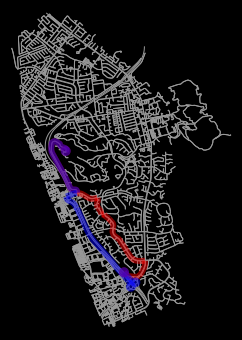

In [19]:
orig = list(osm_graph)[2043]
dest = list(osm_graph)[517]
route1 = nx.shortest_path(osm_graph, orig, dest, weight='length')
route2 = nx.shortest_path(osm_graph, orig, dest, weight='travel_time')
# pick route colors
c1 = 'r' #length
c2 = 'b' #travel_time
rc1 = [c1] * (len(route1) - 1)
rc2 = [c2] * (len(route2) - 1)
rc = rc1 + rc2
nc = [c1, c1, c2, c2]

fig, ax = ox.plot_graph_routes(osm_graph, [route1, route2], route_color=rc, route_linewidth=6,
                               orig_dest_node_color=nc, node_size=0, bgcolor='k')

In [ ]:
fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = nodes, name="Intersection Nodes")
fremont_map.add_data(data = streets, name="Road Network")
fremont_map

In [ ]:
osm_graph_full = ox.core.graph_from_polygon(delimitation_poly, simplify=False)
osm_graph_full = ox.add_edge_speeds(osm_graph)
osm_graph_full = ox.add_edge_travel_times(osm_graph)
nodes_full, streets_full = ox.graph_to_gdfs(osm_graph_full)

In [ ]:
osm_graph_2 = ox.core.graph_from_polygon(delimitation_poly, simplify=False, infrastructure="relation")
osm_graph_2 = ox.add_edge_speeds(osm_graph)
osm_graph_2 = ox.add_edge_travel_times(osm_graph)
nodes_2, streets_2 = ox.graph_to_gdfs(osm_graph_2)

In [ ]:
stop_signs = nodes_full[nodes_full['highway'] == 'stop']
traffic_signals = pd.concat([nodes_full[nodes_full['highway'] == 'traffic_signals'], nodes_2[nodes_2['highway'] == 'traffic_signals']])

fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = nodes_full, name="All Nodes")
fremont_map.add_data(data = stop_signs, name="Stop Signs")
fremont_map.add_data(data = traffic_signals, name="Traffic Signals")
fremont_map

In [ ]:
osm_poi_gdf = ox.pois_from_polygon(delimitation_poly)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', None)

# osm_poi_gdf = osm_poi_gdf[osm_poi_gdf.type == 'Point'][['amenity', 'name', 'geometry']]

for idx, row in osm_poi_gdf.iterrows():
    if osm_poi_gdf.loc[idx,'geometry'].type != 'Point':
        osm_poi_gdf.loc[idx,'geometry'] = osm_poi_gdf.loc[idx,'geometry'].centroid

osm_poi_gdf = osm_poi_gdf[['amenity', 'name', 'geometry']]
osm_poi_gdf = osm_poi_gdf.dropna(subset=['name'])

osm_poi_gdf

In [ ]:
fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = osm_poi_gdf, name="Points of Interest")
fremont_map

In [ ]:
## external centroids with OSM network and closer delimitation

In [ ]:
## Create the external TAZs using Google Maps API

In [ ]:
## Get google maps POIs

In [ ]:
## Get neighborhood information + other shapefile data

In [ ]:
## Do k-mean clustering to create internal centroids

In [ ]:
## Get boundaries of internal TAZs

In [ ]:
## Create TAZs

In [ ]:
## Create centroid connections

In [ ]:
## Create files for Aimsun with centroid connections and centroid and OSM network

See [Aimsun documentation to create the layers](https://www.aimsun.com/tech_notes/gis-import-1/)

In [ ]:
## Download Google Maps tiles corresponding to the project